# Projeto

In [1]:
import sys
import pickle
import pandas as pd
import glob
import numpy as np
sys.path.append("../")
from src.data import load_data as ld
from src.data import make_data as mk
from toolz import compose, partial

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [3]:
df_result = ld.load_datasets(data_source = 'continuous')

In [7]:
df_result.head(2)

VelocityX  VelocityY  VelocityZ  Temperature              datetime                    spotId                                      data_source  AccelerationX  AccelerationY  AccelerationZ
0   1.646576   1.945953  13.397141    34.145937  2019-11-01T00:16:44Z  5c9118a003e04e5aa1335e34  dataset_raw_continuous_5c9118a003e04e5aa1335e34            NaN            NaN            NaN
1   2.619553   2.993774  14.370117    34.317539  2019-11-01T00:22:23Z  5c9118a003e04e5aa1335e34  dataset_raw_continuous_5c9118a003e04e5aa1335e34            NaN            NaN            NaN

## Não supervisionada

In [10]:
def optimal_number_of_clusters(wcss):

    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2


def calculate_wcss(data):

    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        print(n)
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [11]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [12]:
features = ['VelocityX', 'VelocityY', 'VelocityZ', 'Temperature']

In [13]:
sum_of_squares = calculate_wcss(df_result[features])
n = optimal_number_of_clusters(sum_of_squares)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


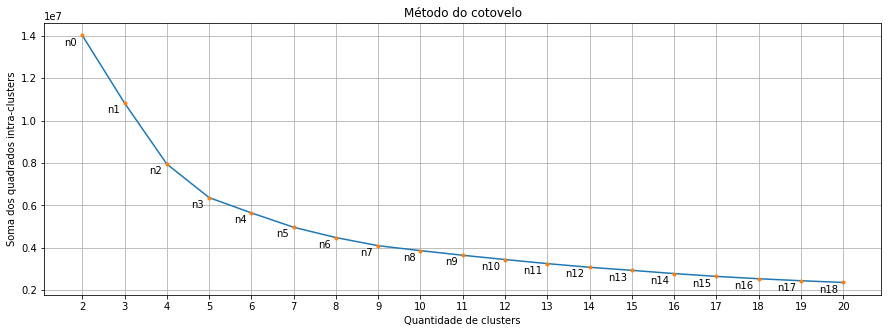

In [17]:
x1, x2 = 2, 20
intervalo = range(x1,x2+1)
plt.figure(figsize=(15,5))
plt.title('Método do cotovelo')
plt.xlabel('Quantidade de clusters')
plt.ylabel('Soma dos quadrados intra-clusters')
plt.grid()
plt.xticks(intervalo)
plt.plot(intervalo, sum_of_squares) # pontos laranjas
plt.plot(intervalo, sum_of_squares, '.') # linha azul
for x,y in zip(intervalo,sum_of_squares): # colocando nome nos pontos
    label = "n{}".format(x-2)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(-5,-10),
                 ha='right')
plt.show()


In [15]:
kmeans = KMeans(n_clusters=n, random_state=42)
clusters = kmeans.fit_predict(df_result[features])

In [18]:
df_result['cluster'] = clusters

In [25]:
df_result.groupby(['cluster']).agg({
#     'VelocityX':'mean',
#     'VelocityY':'mean',
#     'VelocityZ':'mean',
#     'Temperature':'median',
    'VelocityX':'max',
    'VelocityY':'max',
    'VelocityZ':'max',
    'Temperature':'max',
    'cluster':'count'
})

VelocityX  VelocityY  VelocityZ  Temperature  cluster
cluster                                                       
0        54.486694  51.792297  54.486694    41.535530    12778
1        16.465759  17.812958  11.750565    45.139163    52036
2        14.295273  13.921051   5.987549    33.920710   105114
3        12.499008  11.600876   8.981323    28.247134    91773
4        62.869263  63.168640  62.869263   104.599104     7535
5        16.765137  23.650818  45.205994    45.589617    23513
6        13.696518  11.600876  13.172607    22.552107    77977

In [41]:
def make_class_Velocity(x):
    if x <= 0.15:
        x = '_0.15'
    elif x > 0.15 and x < 1.9:
        x = '0.15_1.9'
    else:
        x = '1.9_'
    return x

In [67]:
df_result.VelocityX.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count    370726.000000
mean          1.536859
std           2.342601
min           0.000000
10%           0.074844
20%           0.149689
30%           0.224533
40%           0.374222
50%           0.673599
60%           1.197510
70%           1.646576
80%           2.320175
90%           3.966751
max          62.869263
Name: VelocityX, dtype: float64

In [42]:
df_result['class_VelocityX'] = df_result.VelocityX.apply(make_class_Velocity)
df_result['class_VelocityY'] = df_result.VelocityY.apply(make_class_Velocity)
df_result['class_VelocityZ'] = df_result.VelocityZ.apply(make_class_Velocity)

In [44]:
df_result.Temperature.describe()

count    370726.000000
mean         28.004449
std           6.853534
min          11.280029
25%          23.013286
50%          28.011182
75%          32.065269
max         104.599104
Name: Temperature, dtype: float64

In [50]:
def make_class_Temperature(x):
    if x <= 23:
        x = '_23'
    elif x > 23 and x < 40:
        x = '23_40'
    else:
        x = '40_'
    return x

In [51]:
df_result['class_Temperature'] = df_result.Temperature.apply(make_class_Temperature)

In [52]:
features = ['class_VelocityX', 'class_VelocityY', 'class_VelocityZ', 'class_Temperature']

In [53]:
df_dum = pd.get_dummies(df_result[features])

### NOVO MODELO

In [54]:
sum_of_squares = calculate_wcss(df_dum)
n = optimal_number_of_clusters(sum_of_squares)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [55]:
n

9

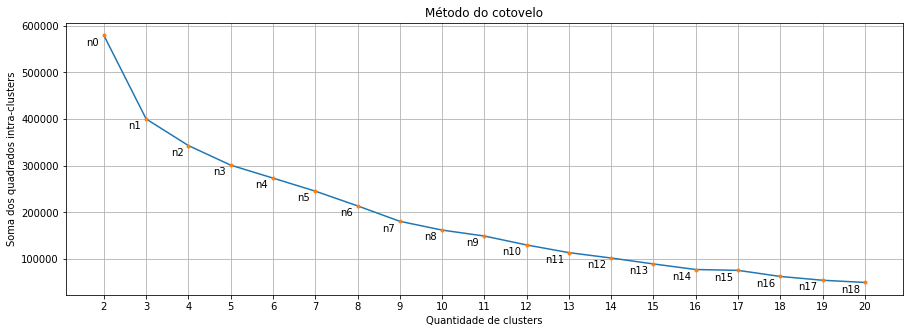

In [56]:
x1, x2 = 2, 20
intervalo = range(x1,x2+1)
plt.figure(figsize=(15,5))
plt.title('Método do cotovelo')
plt.xlabel('Quantidade de clusters')
plt.ylabel('Soma dos quadrados intra-clusters')
plt.grid()
plt.xticks(intervalo)
plt.plot(intervalo, sum_of_squares) # pontos laranjas
plt.plot(intervalo, sum_of_squares, '.') # linha azul
for x,y in zip(intervalo,sum_of_squares): # colocando nome nos pontos
    label = "n{}".format(x-2)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(-5,-10),
                 ha='right')
plt.show()


In [82]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_dum)

In [83]:
df_dum['cluster'] = clusters

In [84]:
list(df_dum)

['class_VelocityX_0.15_1.9',
 'class_VelocityX_1.9_',
 'class_VelocityX__0.15',
 'class_VelocityY_0.15_1.9',
 'class_VelocityY_1.9_',
 'class_VelocityY__0.15',
 'class_VelocityZ_0.15_1.9',
 'class_VelocityZ_1.9_',
 'class_VelocityZ__0.15',
 'class_Temperature_23_40',
 'class_Temperature_40_',
 'class_Temperature__23',
 'cluster']

In [85]:
df_dum.groupby(['cluster']).agg({
'class_VelocityX_0.15_1.9':'sum',
 'class_VelocityX_1.9_':'sum',
 'class_VelocityX__0.15':'sum',
 'class_VelocityY_0.15_1.9':'sum',
 'class_VelocityY_1.9_':'sum',
 'class_VelocityY__0.15':'sum',
 'class_VelocityZ_0.15_1.9':'sum',
 'class_VelocityZ_1.9_':'sum',
 'class_VelocityZ__0.15':'sum',
 'class_Temperature_23_40':'sum',
 'class_Temperature_40_':'sum',
 'class_Temperature__23':'sum',
    'cluster':'count'
})

class_VelocityX_0.15_1.9  class_VelocityX_1.9_  class_VelocityX__0.15  class_VelocityY_0.15_1.9  class_VelocityY_1.9_  class_VelocityY__0.15  class_VelocityZ_0.15_1.9  class_VelocityZ_1.9_  class_VelocityZ__0.15  class_Temperature_23_40  class_Temperature_40_  class_Temperature__23  cluster
cluster                                                                                                                                                                                                                                                                                                     
0                         14709.0                 275.0               105580.0                   15395.0                 126.0               105043.0                   31663.0                  48.0                88853.0                  46698.0                  787.0                73079.0   120564
1                        116308.0               18935.0                 3477.0                  121547.0               12289.0                 4884.0                  136650.0                   0.0                 2070.0                 126059.0                 4218.0                 8443.0   138720
2                         18977.0               10575.0                    7.0                   29554.0                   0.0                    5.0                       0.0               29559.0                    0.0                  27967.0                  233.0                 1359.0    29559
3                         16490.0               65089.0                  304.0                    1289.0               80435.0                  159.0                   19037.0               62746.0                  100.0                  64660.0                 7725.0                 9498.0    81883

In [79]:
df_result['cluster'] = clusters

In [80]:
pd.pivot_table(df_result, values=['data_source'],
               index='spotId', columns=['cluster'], aggfunc='count')

data_source              
cluster                            0      1      2
spotId                                            
5c91189fd632ea7d772b3dad        7010   8086    670
5c9118a003e04e5aa1335e34        9778   5818    195
5cec48ea28de953f27a6e62d        7283   3942   6702
5cec4b5028de956244a6e663        3439   8421   2240
5cec4f0992c770c686d2ef99        1298   7474   3905
5cefcf6f91e6c5a6c8461706        1683    341  16618
5d24e6bda996d762447e46e7        6571   5364   1768
5d3b3edb2723c663aaa6407b        8093    165   7859
5d40996d7ea002739b1a1345        4100   1344   8464
5d431960b75779e4703f8016        6974   8194   1826
5d43197cb75779ca9f3f801d        5998   2806   8698
5d4b1f034bfdcc3db9ec4353        4799   8918   3563
5d5460fa3907163d586b0b5d        2802  12825   2783
5d57007ec6d443792ab78f62        1776   5853   5865
5d6eb5f7269ac933525124da        5211    749   6364
5d6eb5fa74937315e25e8127        7073   1241   4768
5d6f9aa06a834a634f59c65a        6381   2101   3108
5d77b67bea96c2fe5753a594        9158   4247   1744
5d79397465736a62ec2037cb        2261    984   5212
5d7a6f42eae7ea25c960103a        3277   1382   8375
5d91e7a204468e6d8ca4d575        3042   1233   8224
5d95dac004468e56d6b907af        2830   3602   1928
5d95dac168dc086adb61e5f5        4427   4664   3469
5d9f653bd5ea19324b65ec7c        7188   6257   1268
5e4597f36adcaa07d6bc5d0a        5111    441  10468
5e4c18bb9632ebcddf94a50e        1260   1450   7917

## Process Data

In [4]:
df_test = mk.make_dataset_processed(df_result)

In [32]:
def get_fft(input_list, fs, average=False,window=False):
    input_list = pd.Series(input_list)
    if not average:

        N = int(len(input_list))
        if window:
            w = signal.hanning(N)
            input_list=input_list*w
            input_list = input_list-np.mean(input_list)
                
        FFT_full = np.fft.fft(input_list) / N
        print(len(FFT_full))
        print(len(fs))
        freqVec_full = np.fft.fftfreq(len(FFT_full), 1/fs)
        j = freqVec_full > 0
        FFT_onesided = FFT_full[j]
        freqVec_onesided = freqVec_full[j]
    #freqVec_onesided, 2*FFT_onesided, FFT_full
    return list(2*FFT_onesided)

In [33]:
samplingRate = []
for i in range(len(df_result)):
    samplingRate.append(df_result.spectralSettings[i]['samplingRate'])
df_result['samplingRate'] = samplingRate

In [34]:
get_fft_fs = partial(get_fft, fs=df_result['samplingRate'])

In [35]:
df_result['X_fft'] = df_result['X'].apply(get_fft_fs)
df_result['Y_fft'] = df_result['Y'].apply(get_fft_fs)
df_result['Z_fft'] = df_result['Z'].apply(get_fft_fs)

8192
4878


ValueError: operands could not be broadcast together with shapes (8192,) (4878,) 

In [ ]:
def make_dataset_processed(df):
    samplingRate = []
    for i in range(len(df)):
        samplingRate.append(df.spectralSettings[i]['samplingRate'])
    df['samplingRate'] = samplingRate
    acc_to_vel_fs = partial(acc_to_vel, fs=df_result['samplingRate'])
    df['X_vel'] = df['X'].apply(acc_to_vel_fs)
    df['Y_vel'] = df['Y'].apply(acc_to_vel_fs)
    df['Z_vel'] = df['Z'].apply(acc_to_vel_fs)
    
    return df
    

In [24]:
acc_to_vel(pd.Series(df_result['X'][0]), fs=df_result.spectralSettings[0]['samplingRate'], cutoff=0, order=0, convert=False)

0       0.000486
1       0.000481
2       0.000477
3       0.000480
4       0.000475
          ...   
8187    0.000464
8188    0.000475
8189    0.000477
8190    0.000480
8191    0.000483
Length: 8192, dtype: float64


In [4]:
df_result

_id                               axis                                   spectralSettings                    spotId             startedAt            finishedAt          downloadDate                                               spot             createdAt             updatedAt fs_valid samples_valid                                                  X                                                  Y                                                  Z  \
0     5efef21db9811ca683503236  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-07-03T04:46:07Z  2020-07-03T04:46:07Z  2020-07-03T08:53:49Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-07-03T08:53:49Z  2020-07-03T08:53:49Z     True          True  [0.046875, 0.03125, 0.03125, 0.046875, 0.03125...  [-0.9375, -0.9375, -0.9375, -0.953125, -0.9531...  [0.015625, 0.015625, 0, 0, 0.015625, 0.03125, ...   
1     5efd69ffed9968aa7ff47a88  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-07-02T04:48:21Z  2020-07-02T04:48:21Z  2020-07-02T05:00:47Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-07-02T05:00:47Z  2020-07-02T05:00:47Z     True          True  [0.046875, 0.03125, 0.046875, 0.046875, 0.0468...  [-0.921875, -0.90625, -0.921875, -0.921875, -0...  [0.03125, 0.046875, 0.03125, 0.03125, 0.03125,...   
2     5ef97837ed9968dc50c6009f  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-06-29T05:11:27Z  2020-06-29T05:11:27Z  2020-06-29T05:12:23Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-06-29T05:12:23Z  2020-06-29T05:12:23Z     True          True  [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.046...  [-0.890625, -0.890625, -0.90625, -0.890625, -0...  [0.03125, 0.015625, 0.015625, 0.015625, 0.0312...   
3     5ef81e78ed9968e608bf0c00  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-06-28T04:36:50Z  2020-06-28T04:36:50Z  2020-06-28T04:37:12Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-06-28T04:37:12Z  2020-06-28T04:37:12Z     True          True  [0.046875, 0.046875, 0.046875, 0.046875, 0.046...  [-0.890625, -0.890625, -0.890625, -0.890625, -...  [0.03125, 0.03125, 0.03125, 0.03125, 0.03125, ...   
4     5ef6ce40b9811cf4d7f2e48a  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-06-27T04:41:59Z  2020-06-27T04:41:59Z  2020-06-27T04:42:40Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-06-27T04:42:40Z  2020-06-27T04:42:40Z     True          True  [0, 0.03125, 0.046875, 0.03125, 0.0625, 0.0156...  [-0.921875, -0.921875, -0.953125, -0.953125, -...  [0.015625, 0.015625, 0.046875, 0.046875, 0.031...   
...                        ...                                ...                                                ...                       ...                   ...                   ...                   ...                                                ...                   ...                   ...      ...           ...                                                ...                                                ...                                                ...   
4873  5e6106ab451562a24e3391c3  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5d431960b75779e4703f8016  2020-03-05T12:37:02Z  2020-03-05T12:37:02Z  2020-03-05T14:03:23Z  {'_id': '5d431960b75779e4703f8016', 'name': 'M...  2020-03-05T14:03:23Z  2020-05-23T17:43:22Z     True          True  [-0.125, -0.125, -0.125, -0.125, -0.125, -0.12...  [-1.015625, -1.015625, -1.015625, -1.015625, -...  [-0.03125, -0.03125, -0.015625, -0.015625, -0....   
4874  5e5fb6e95c118750d5b354e8  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5d431960b75779e4703f8016  2020-03-04T12:36:48

In [30]:
def resume_data_mean(param):
    param_mean = round(np.mean(param),2)
    return param_mean

In [31]:
def resume_data_median(param):
    param_median = round(np.median(param),2)
    return param_median

In [32]:
def resume_data_std(param):
    param_std = round(np.std(param),2)
    return param_std

In [33]:
df_result['X_mean'] = df_result['X'].apply(resume_data_mean)
df_result['X_median'] = df_result['X'].apply(resume_data_median)
df_result['X_std'] = df_result['X'].apply(resume_data_std)

df_result['Y_mean'] = df_result['Y'].apply(resume_data_mean)
df_result['Y_median'] = df_result['Y'].apply(resume_data_median)
df_result['Y_std'] = df_result['Y'].apply(resume_data_std)

df_result['Z_mean'] = df_result['Z'].apply(resume_data_mean)
df_result['Z_median'] = df_result['Z'].apply(resume_data_median)
df_result['Z_std'] = df_result['Z'].apply(resume_data_std)

### Análise Exploratória

In [35]:
df_result.head(2)

_id                               axis                                   spectralSettings                    spotId             startedAt            finishedAt          downloadDate                                               spot             createdAt             updatedAt fs_valid samples_valid                                                  X                                                  Y                                                  Z  \
0  5efef21db9811ca683503236  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-07-03T04:46:07Z  2020-07-03T04:46:07Z  2020-07-03T08:53:49Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-07-03T08:53:49Z  2020-07-03T08:53:49Z     True          True  [0.046875, 0.03125, 0.03125, 0.046875, 0.03125...  [-0.9375, -0.9375, -0.9375, -0.953125, -0.9531...  [0.015625, 0.015625, 0, 0, 0.015625, 0.03125, ...   
1  5efd69ffed9968aa7ff47a88  {'x': True, 'y': True, 'z': True}  {'axis': {'z': True, 'y': True, 'x': True}, 'd...  5cec48ea28de953f27a6e62d  2020-07-02T04:48:21Z  2020-07-02T04:48:21Z  2020-07-02T05:00:47Z  {'_id': '5cec48ea28de953f27a6e62d', 'name': 'M...  2020-07-02T05:00:47Z  2020-07-02T05:00:47Z     True          True  [0.046875, 0.03125, 0.046875, 0.046875, 0.0468...  [-0.921875, -0.90625, -0.921875, -0.921875, -0...  [0.03125, 0.046875, 0.03125, 0.03125, 0.03125,...   

                                     data_source  X_mean  X_median  X_std  Y_mean  Y_median  Y_std  Z_mean  Z_median  Z_std  
0  dataset_raw_spectral_5cec48ea28de953f27a6e62d    0.04      0.05   0.01   -0.94     -0.94   0.02    0.02      0.02   0.01  
1  dataset_raw_spectral_5cec48ea28de953f27a6e62d    0.04      0.05   0.01   -0.91     -0.91   0.01    0.03      0.03   0.01

Total de _id únicos

In [36]:
df_result['_id'].nunique()

4878

In [37]:
df_result['spotId'].nunique()

25

In [39]:
df_result['year-month'] = pd.to_datetime(df_result['createdAt']).dt.to_period('M')

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [43]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['_id'].count()

In [48]:
df_agg['_id'].describe()

count    208.000000
mean      23.451923
std       13.288970
min        1.000000
25%       14.000000
50%       26.000000
75%       30.000000
max      107.000000
Name: _id, dtype: float64

### Análise X

<AxesSubplot:xlabel='year-month'>

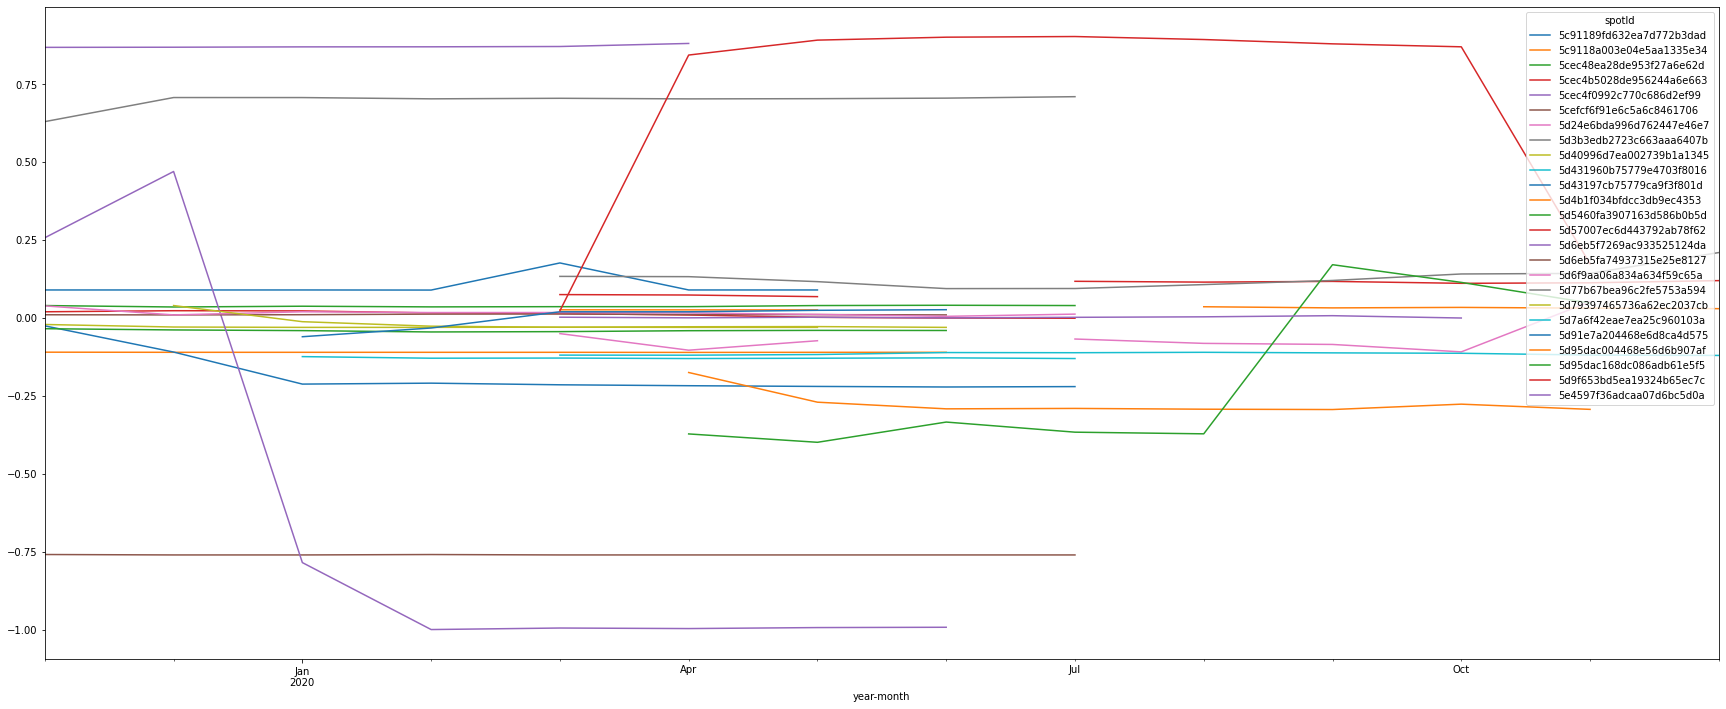

In [60]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['X_mean'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='X_mean')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

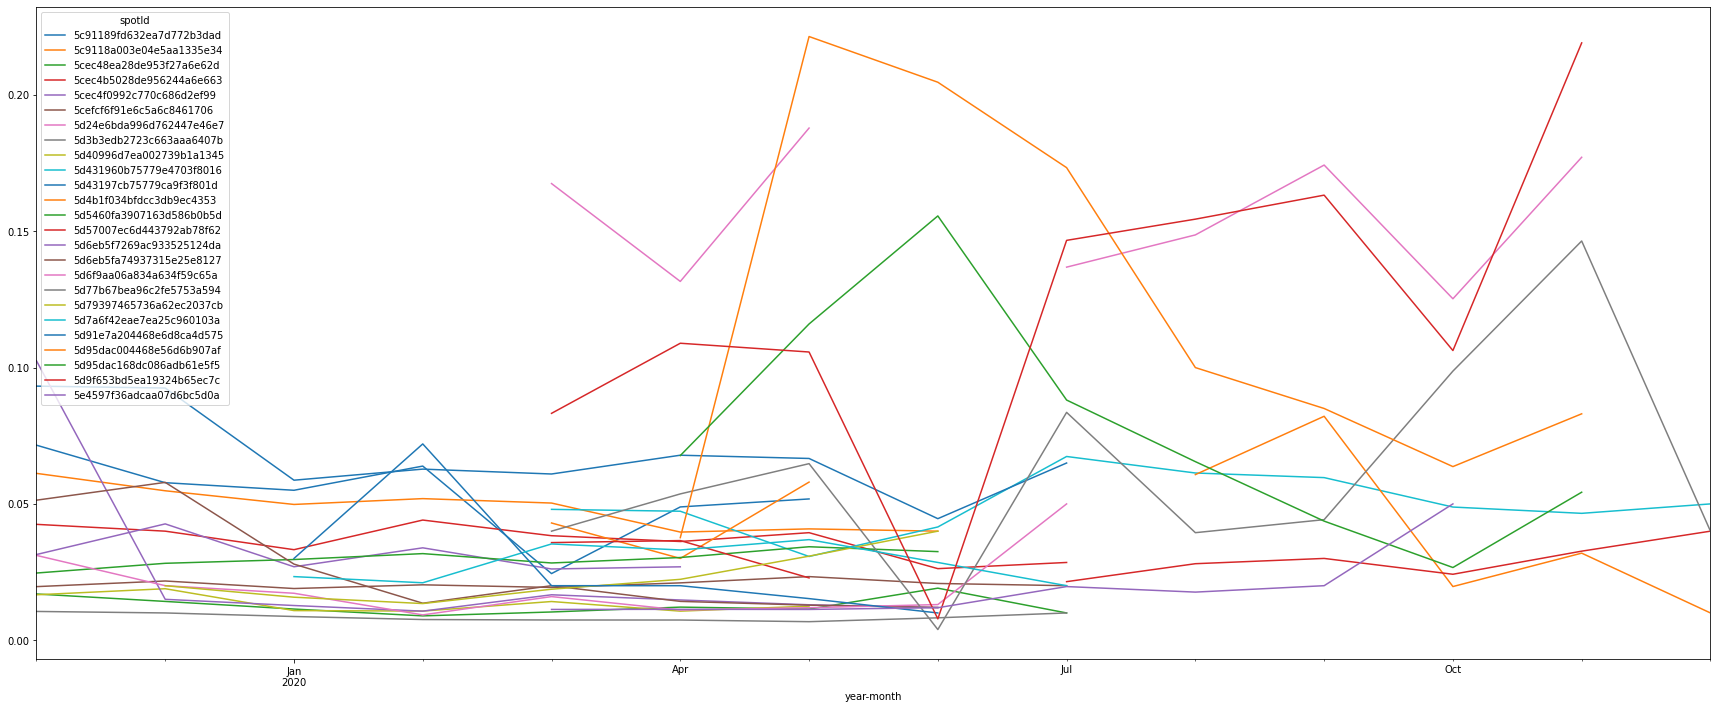

In [61]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['X_std'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='X_std')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

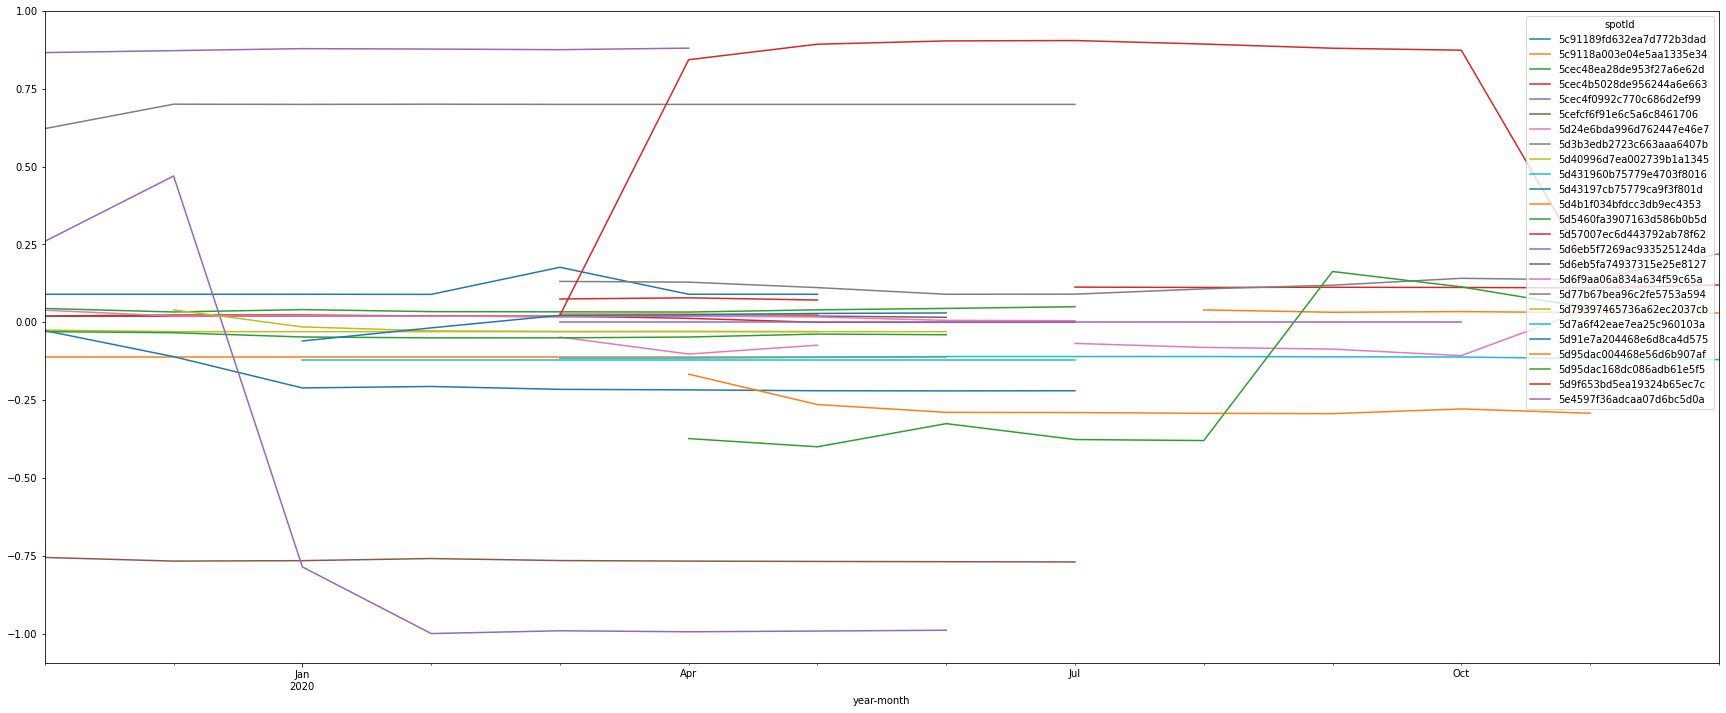

In [62]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['X_median'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='X_median')

df.plot(figsize=(30,12))

### Análise Y

<AxesSubplot:xlabel='year-month'>

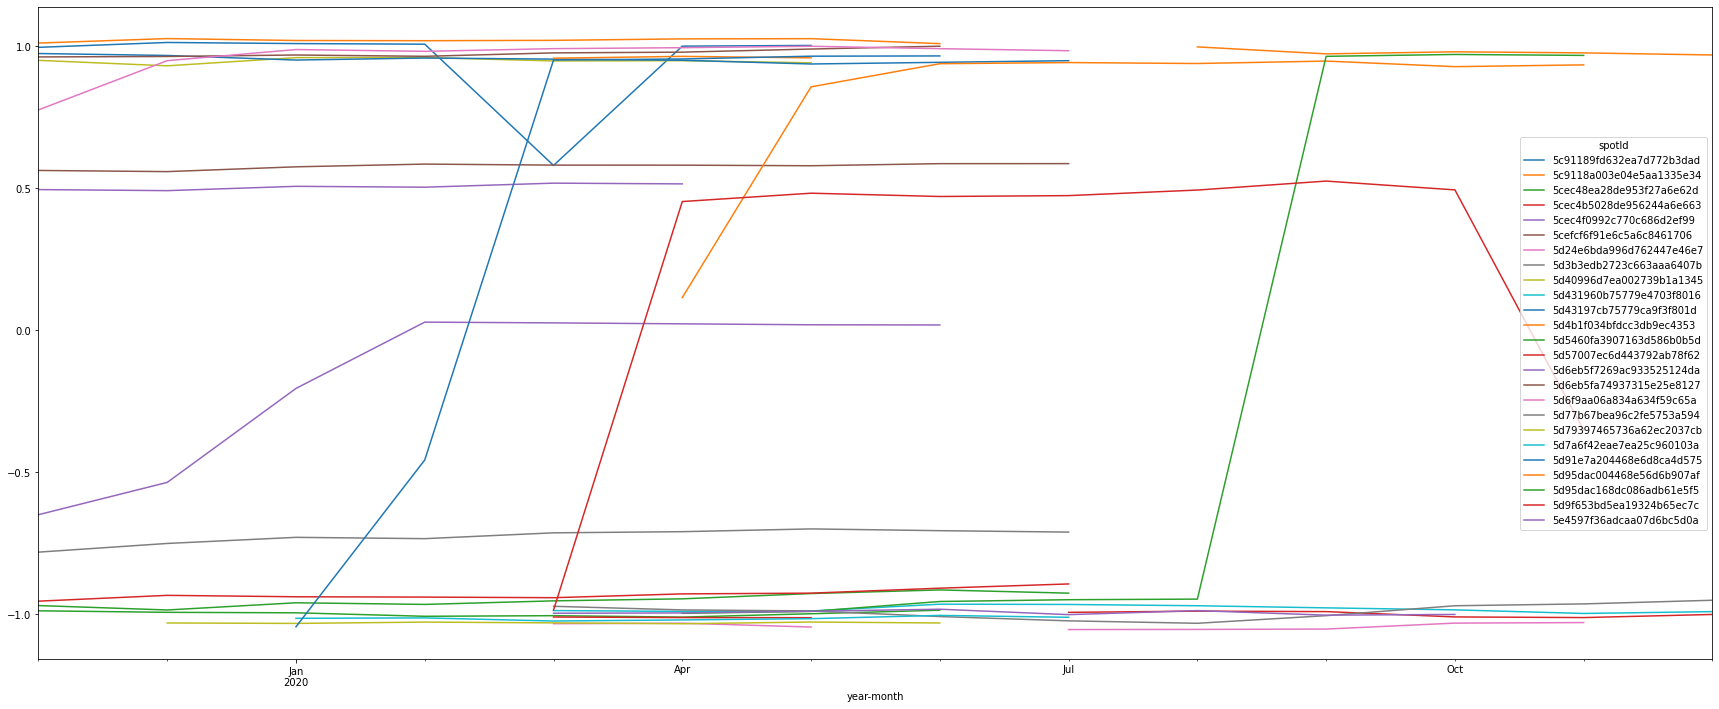

In [63]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Y_mean'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Y_mean')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

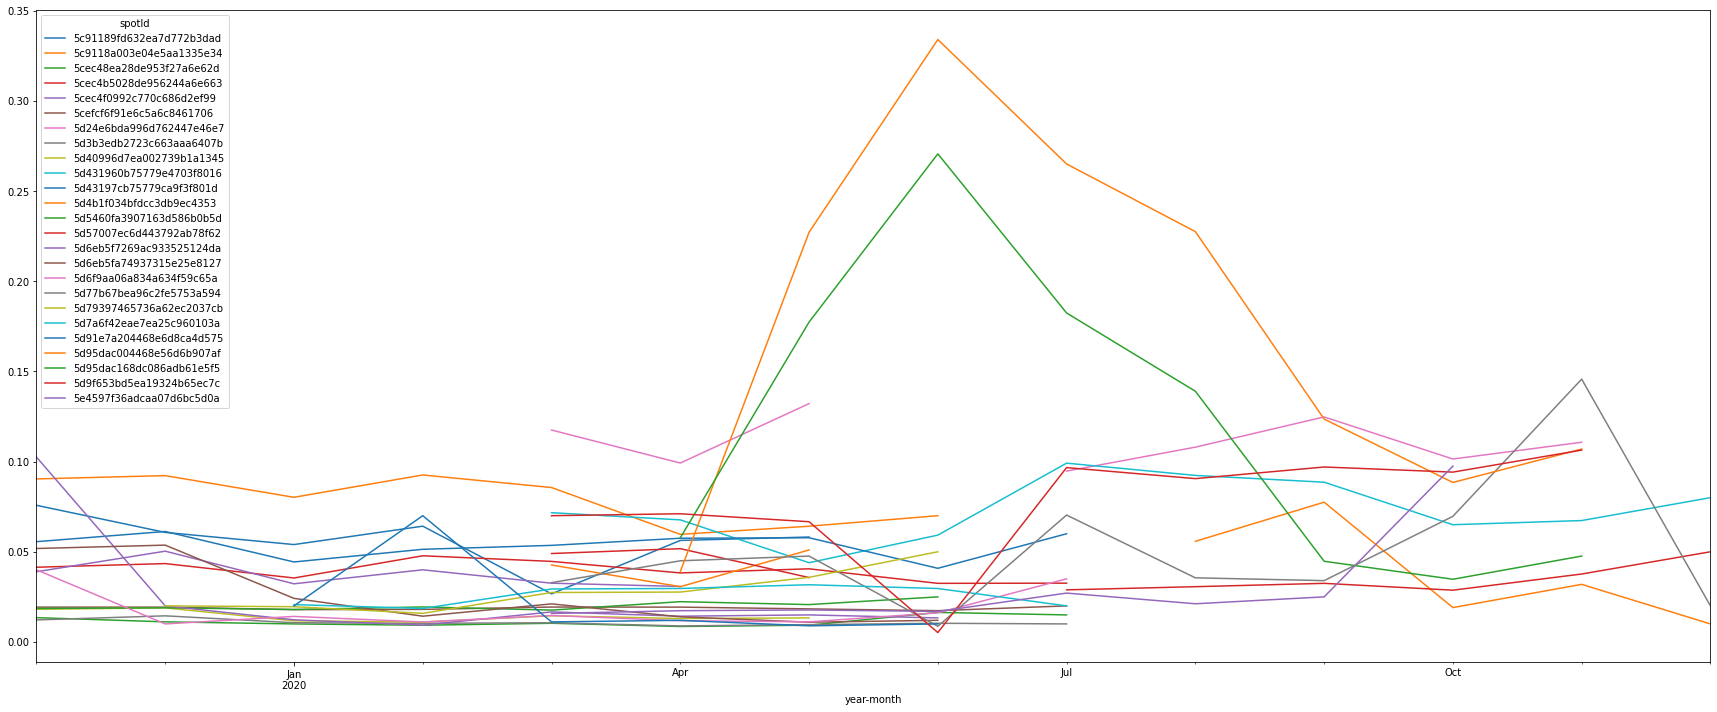

In [64]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Y_std'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Y_std')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

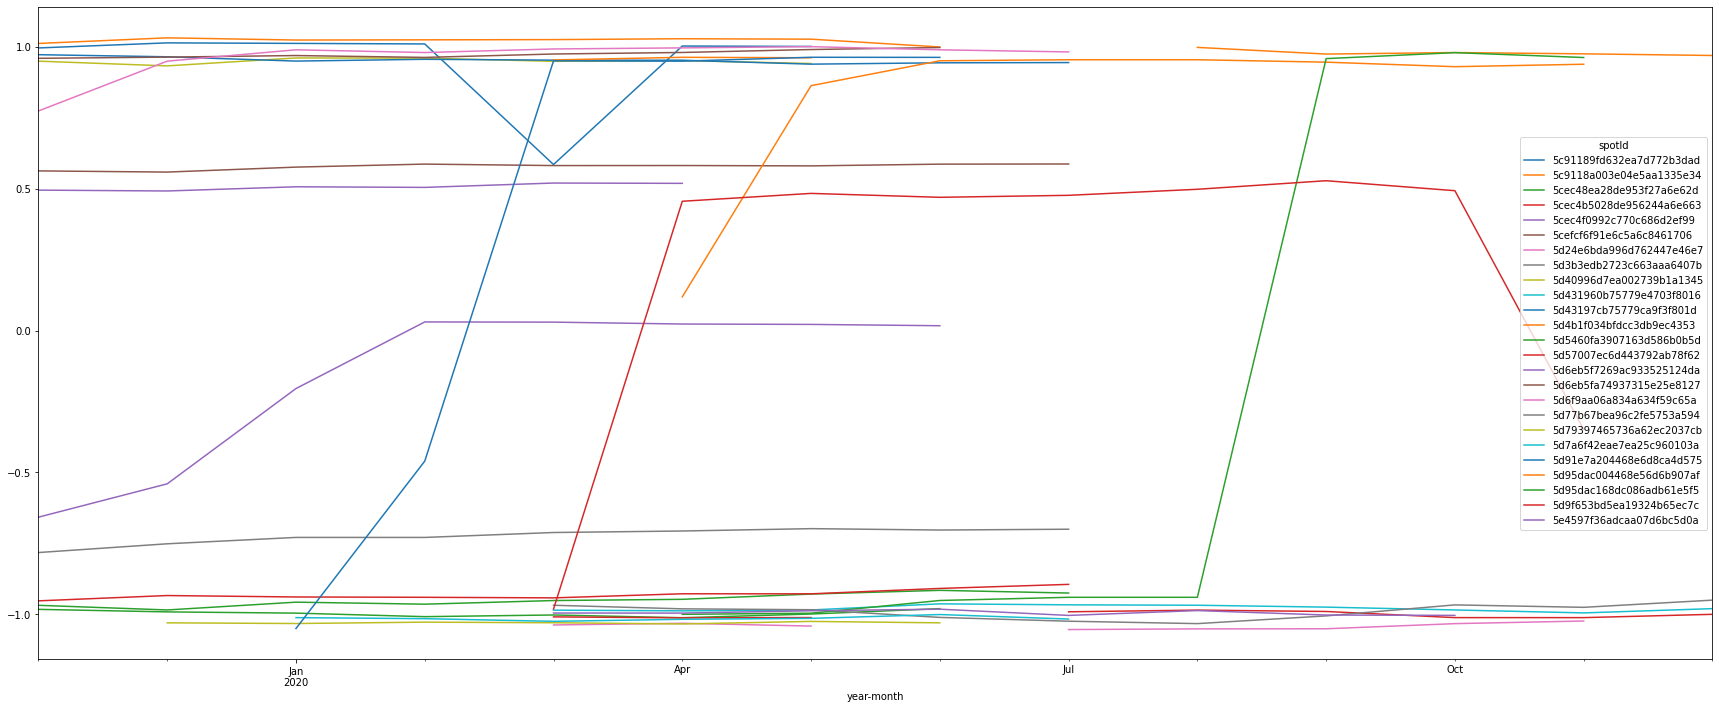

In [65]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Y_median'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Y_median')

df.plot(figsize=(30,12))

### Análise Z

<AxesSubplot:xlabel='year-month'>

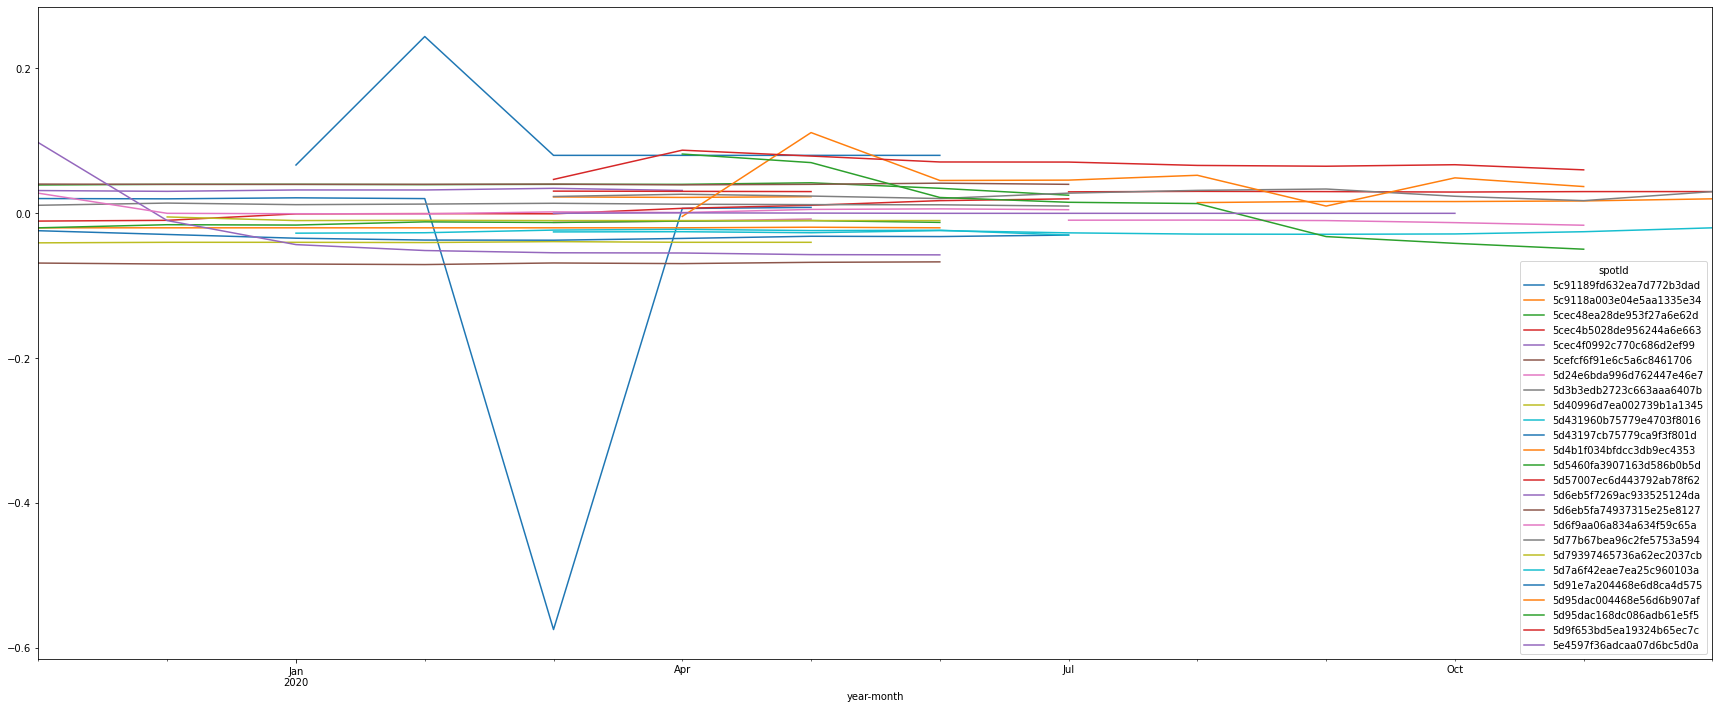

In [51]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Z_mean'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Z_mean')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

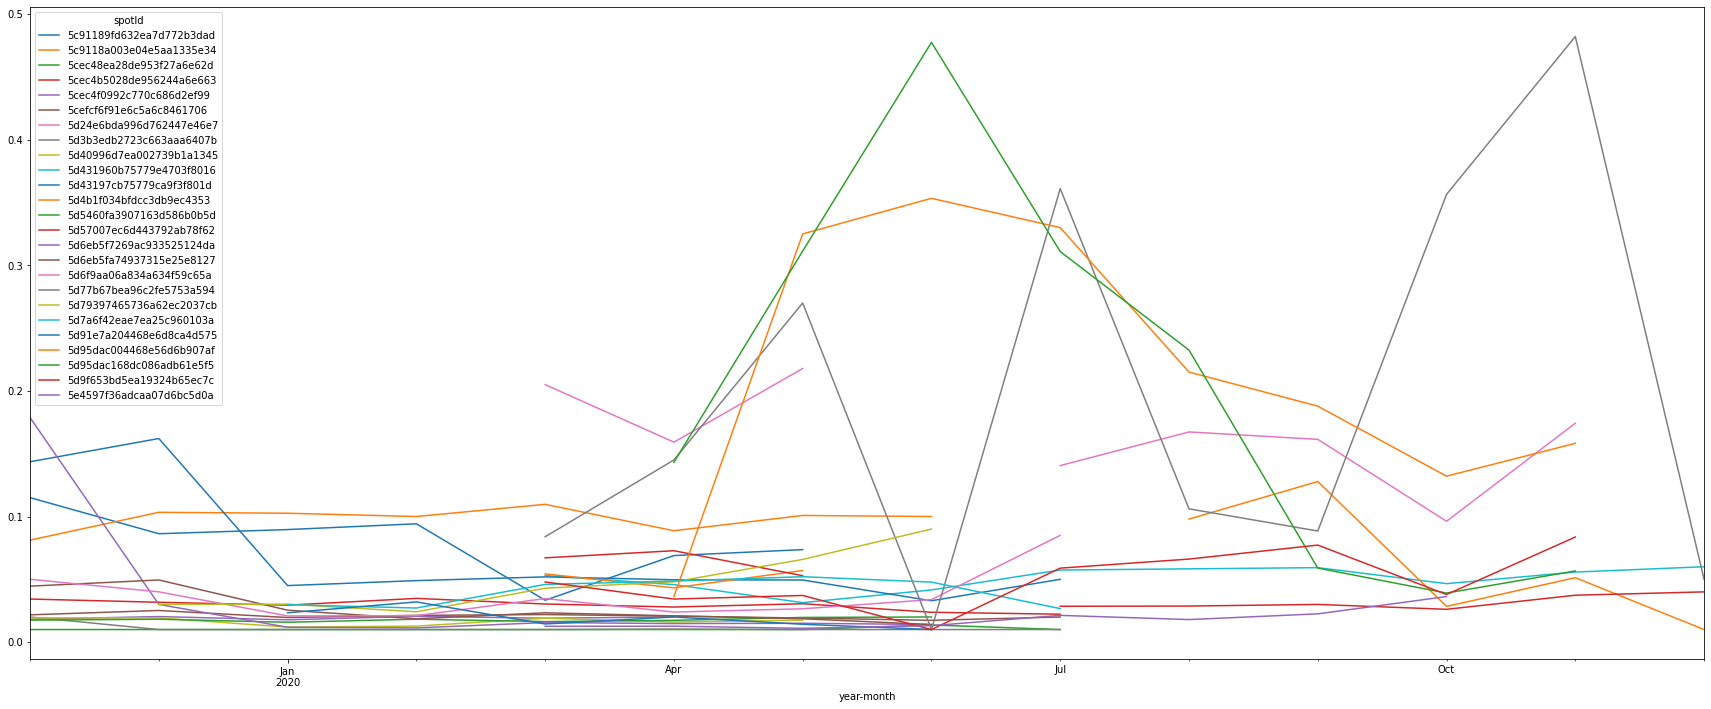

In [53]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Z_std'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Z_std')

df.plot(figsize=(30,12))

<AxesSubplot:xlabel='year-month'>

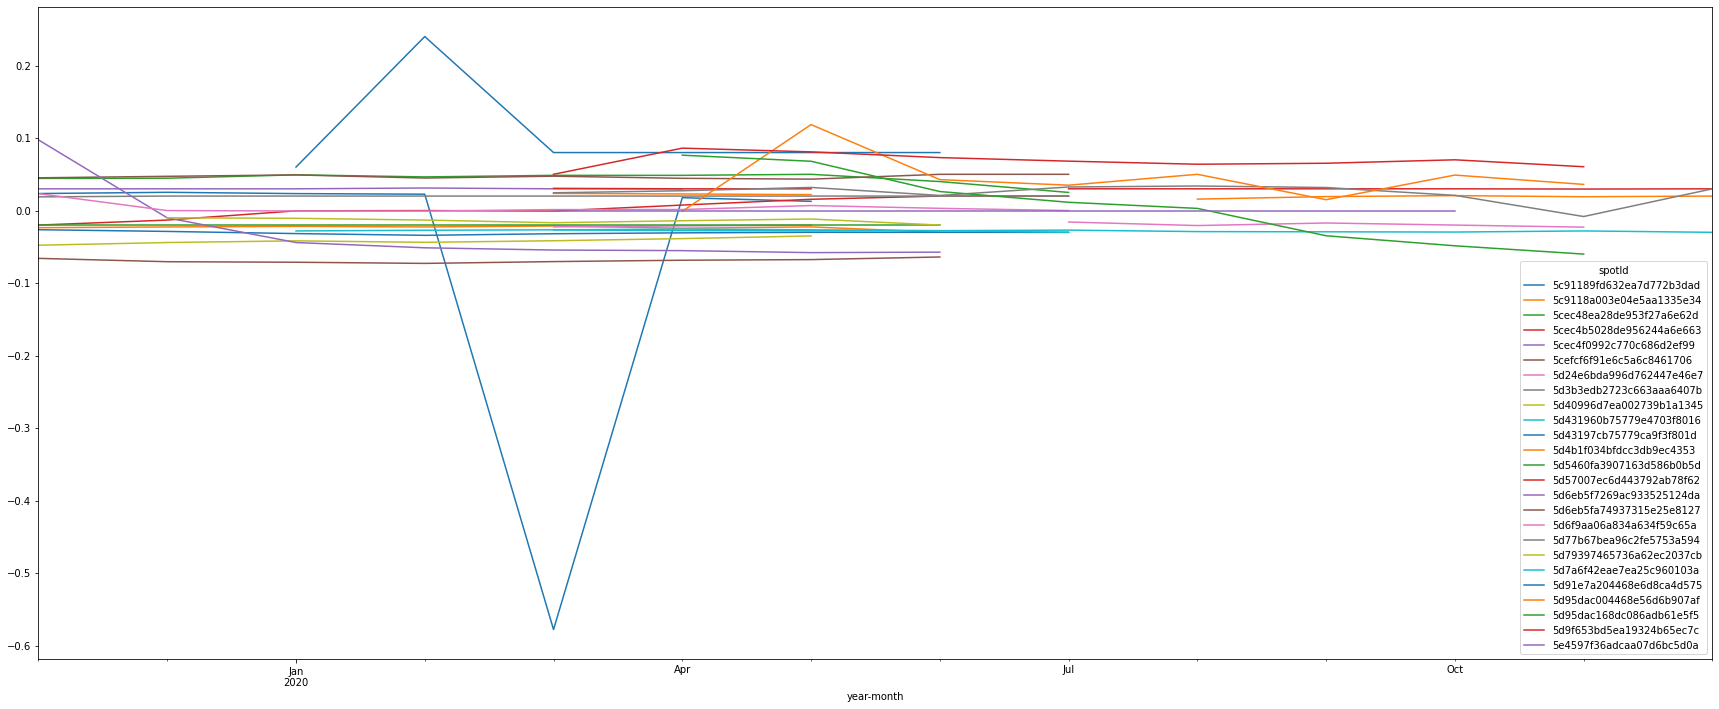

In [54]:
df_agg = df_result.groupby(['year-month', 'spotId'],as_index=False)['Z_median'].mean()
df = df_agg.pivot(index='year-month', columns='spotId', values='Z_median')

df.plot(figsize=(30,12))

### Semana do mes

In [69]:
import pandas as pd
import math

def add_week_of_month(df):
    df['week_in_month'] = pd.to_numeric(df.index.day/7)
    df['week_in_month'] = df['week_in_month'].apply(lambda x: math.ceil(x))
    return df

In [70]:
df = test = pd.DataFrame({'count':['a','b','c','d','e']},
                     index = ['2018-01-01', '2018-01-08','2018-01-31','2018-02-01','2018-02-28'])
df.index = pd.to_datetime(df.index)

In [71]:
add_week_of_month(df)

count  week_in_month
2018-01-01     a              1
2018-01-08     b              2
2018-01-31     c              5
2018-02-01     d              1
2018-02-28     e              4

In [10]:
df_full.target.value_counts()

1    67
0    39
Name: target, dtype: int64

In [156]:
df_full.Datetime.nunique()

89

In [8]:
X = df_full.drop(columns=['Datetime', 'target'])

In [9]:
y = df_full.target

In [ ]:

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd


def qualy_metrics(y_test, y_pred):
    qualy_metrics_resp = {
        'accuracy_score': metrics.accuracy_score(y_test, y_pred),
        'balanced_accuracy_score': metrics.balanced_accuracy_score(y_test, y_pred),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'precision_score': metrics.precision_score(y_test, y_pred),
        'recall_score': metrics.recall_score(y_test, y_pred),
        'jaccard_score': metrics.jaccard_score(y_test, y_pred),
        'roc_auc_score': metrics.roc_auc_score(y_test, y_pred)
    }
    return round(pd.Series(qualy_metrics_resp) * 100, 3)


def qualy_metrics_full(y_test, y_pred, y_train, y_pred_train):
    resp = pd.concat([qualy_metrics(y_train, y_pred_train), qualy_metrics(y_test, y_pred)], axis=1)
    resp.columns = ['Train', 'Test']
    return resp


def confusion_matrix_result(y_test, y_pred):
    conf_matrix_result = confusion_matrix(y_test, y_pred)
    return conf_matrix_result


In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [162]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [163]:
q_metrics = qualy_metrics_full(y_test, model.predict(X_test), y_train, model.predict(X_train))
conf_mat = confusion_matrix_result(y_test, y_pred)

In [164]:
q_metrics

Train    Test
accuracy_score           86.905  68.182
balanced_accuracy_score  86.275  69.643
f1_score                 89.524  72.000
precision_score          90.385  81.818
recall_score             88.679  64.286
jaccard_score            81.034  56.250
roc_auc_score            86.275  69.643

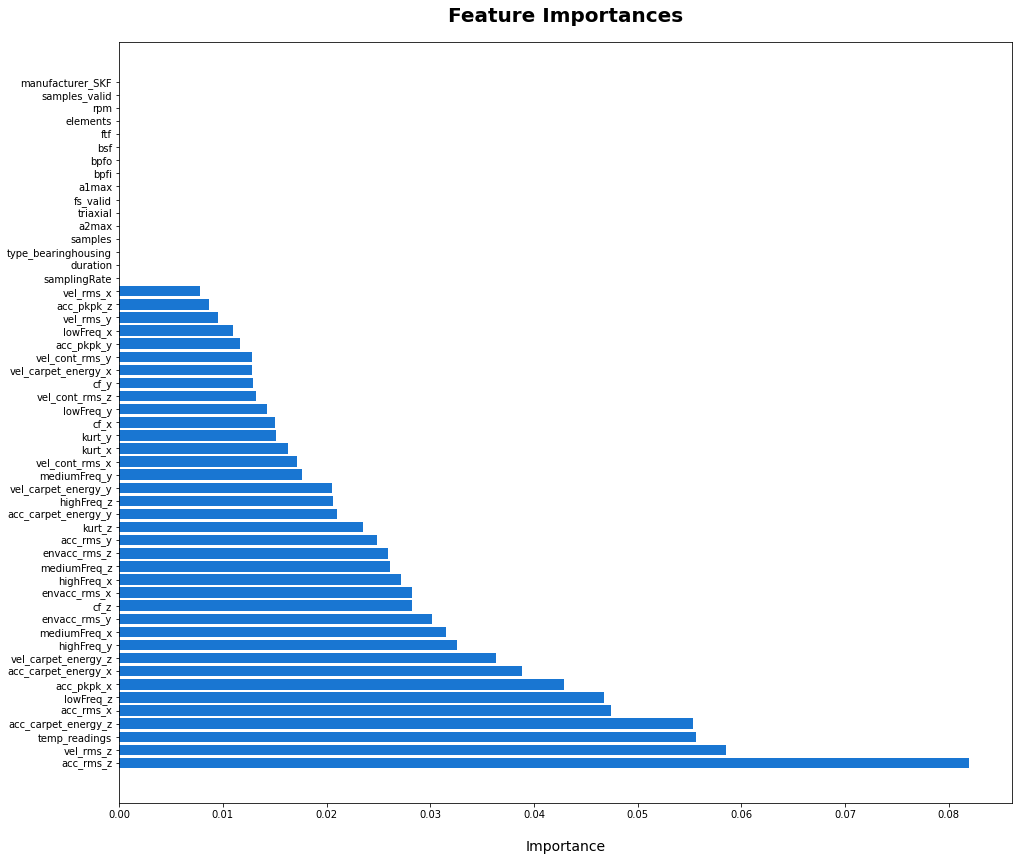

In [165]:
dset = pd.DataFrame()
dset['Feature'] = X.columns
dset['Importance'] = model.feature_importances_

dset = dset.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['Feature'], width=dset['Importance'], color='#1976D2')
plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [166]:
def make_z_x_y(x):
	if x.find('_x')>0:
		x = 'x'
	elif x.find('_y')>0:
		x = 'y'
	elif x.find('_z')>0:
		x = 'z'
	else:
		x = 'others'
		return x
	return x

In [167]:
dset['eixo'] = dset['Feature'].apply(make_z_x_y)

<AxesSubplot:xlabel='eixo'>

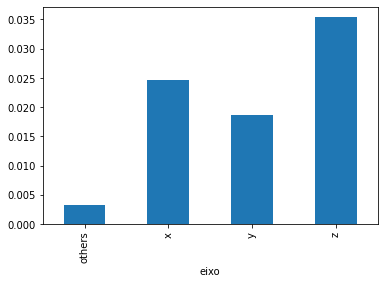

In [168]:
dset.groupby('eixo')['Importance'].mean().plot(kind='bar')

z
others
x
y


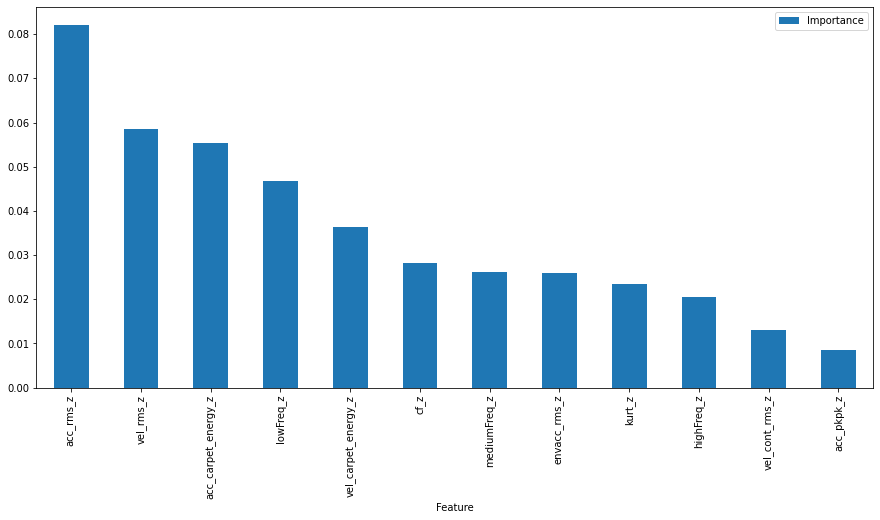

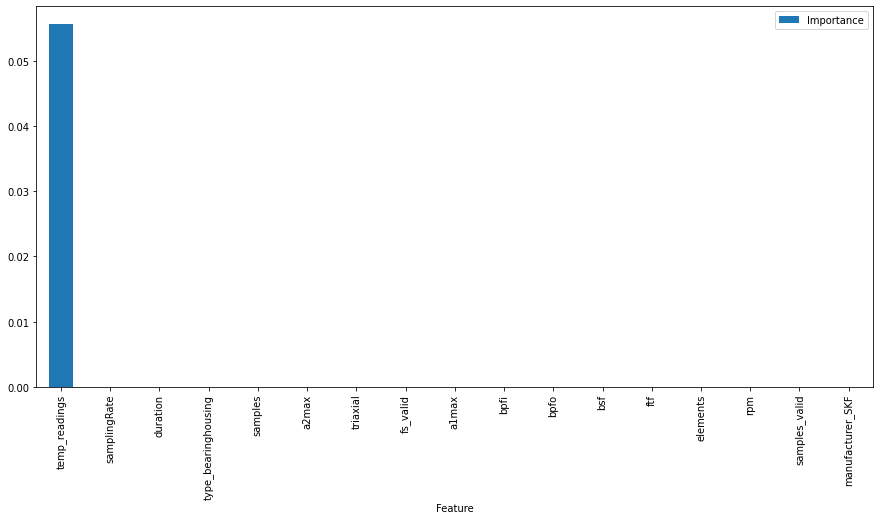

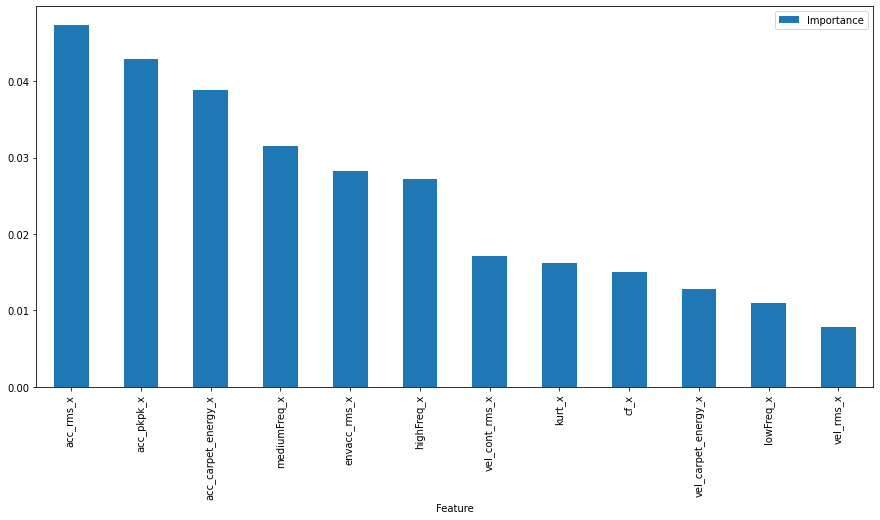

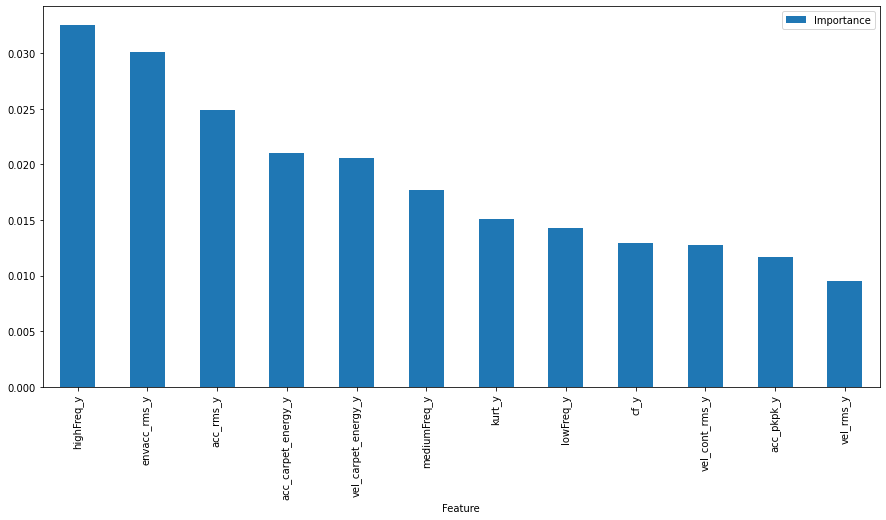

In [169]:
for e in dset.eixo.unique():
    print(e)
    dset[dset.eixo == e].plot(x='Feature', y='Importance', kind='bar', figsize=(15,7))

In [91]:
dset.head(10)['Feature'].values

array(['acc_rms_z', 'vel_rms_z', 'temp_readings', 'acc_carpet_energy_z',
       'acc_rms_x', 'lowFreq_z', 'acc_pkpk_x', 'acc_carpet_energy_x',
       'vel_carpet_energy_z', 'highFreq_y'], dtype=object)

### Teste 2

In [172]:
df_features_importances = dset.copy()

In [173]:
X = df_full[df_features_importances.head(10)['Feature'].values]

In [174]:
y = df_full.target

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [185]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [186]:
q_metrics = qualy_metrics_full(y_test, model.predict(X_test), y_train, model.predict(X_train))
conf_mat = confusion_matrix_result(y_test, y_pred)

In [187]:
q_metrics

Train    Test
accuracy_score           86.905  63.636
balanced_accuracy_score  85.606  60.714
f1_score                 89.720  71.429
precision_score          88.889  71.429
recall_score             90.566  71.429
jaccard_score            81.356  55.556
roc_auc_score            85.606  60.714

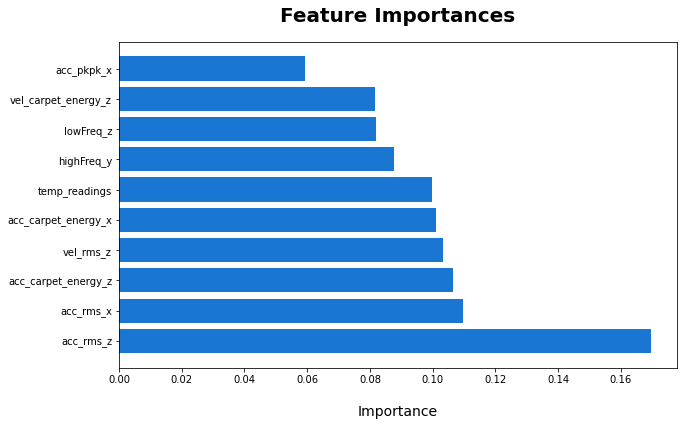

In [179]:
dset = pd.DataFrame()
dset['Feature'] = X.columns
dset['Importance'] = model.feature_importances_

dset = dset.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(y=dset['Feature'], width=dset['Importance'], color='#1976D2')
plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Selecao

In [10]:
X = df_full.drop(columns=['Datetime', 'target'])

In [11]:
y = df_full.target

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
q_metrics = qualy_metrics_full(y_test, model.predict(X_test), y_train, model.predict(X_train))
conf_mat = confusion_matrix_result(y_test, y_pred)

In [17]:
q_metrics

Train    Test
accuracy_score           86.486  62.500
balanced_accuracy_score  84.938  62.771
f1_score                 89.362  68.421
precision_score          87.500  76.471
recall_score             91.304  61.905
jaccard_score            80.769  52.000
roc_auc_score            84.938  62.771

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
              scoring='precision', verbose=2)
rfecv.fit(X_train, y_train)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 fe

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
      scoring='precision', verbose=2)

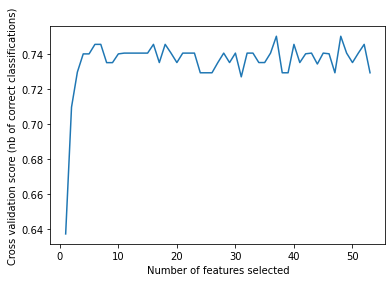

In [21]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

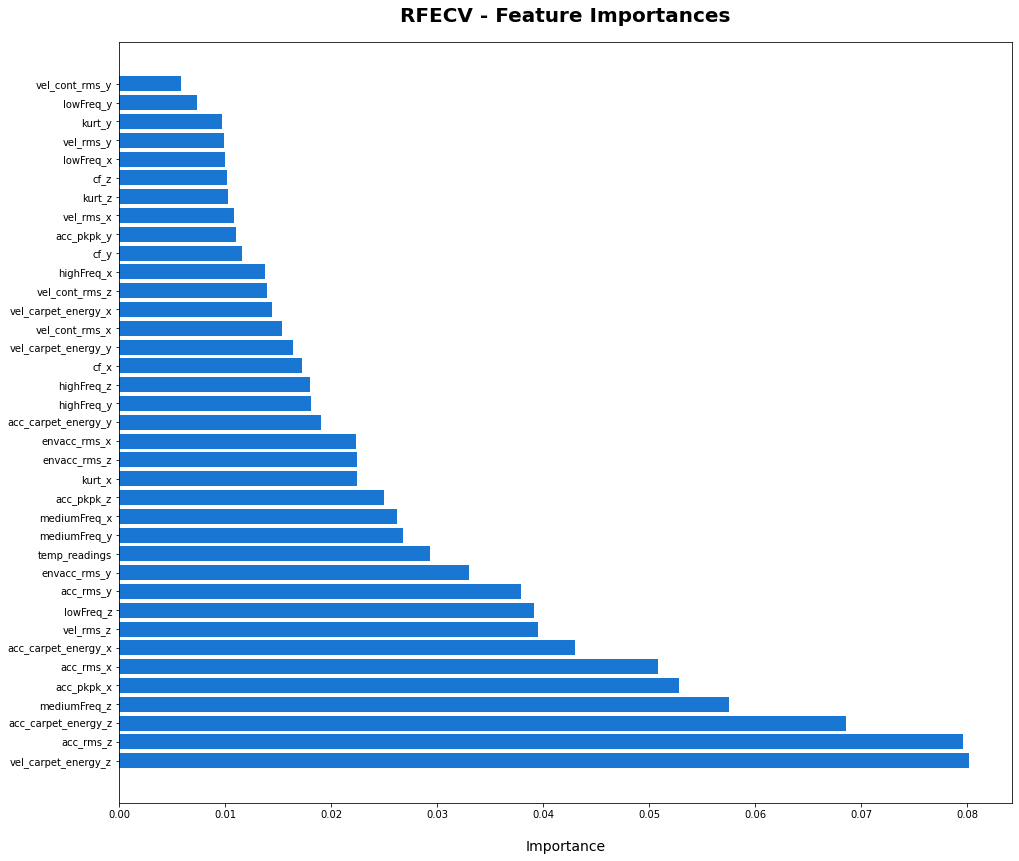

In [22]:
dset = pd.DataFrame()
dset['Feature'] = X_train.columns[rfecv.support_]
dset['Importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['Feature'], width=dset['Importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [27]:
list(dset.head(10)['Feature'])

['vel_carpet_energy_z',
 'acc_rms_z',
 'acc_carpet_energy_z',
 'mediumFreq_z',
 'acc_pkpk_x',
 'acc_rms_x',
 'acc_carpet_energy_x',
 'vel_rms_z',
 'lowFreq_z',
 'acc_rms_y']

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
import math, os, sys  

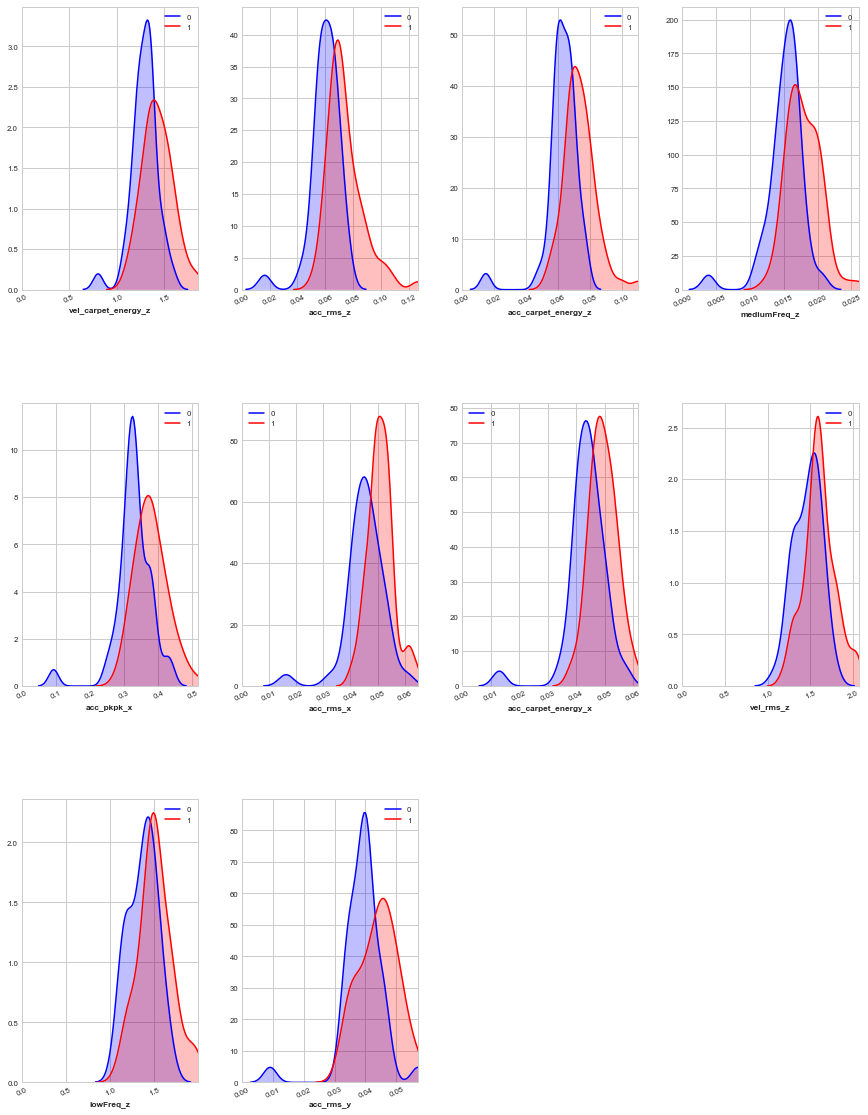

In [29]:
## Variáveis Contínuas - escala bruta

def univariate_kdeplots(dataframe, plot_features, cols=2, width=10, height=10, hspace=0.2, wspace=0.25):
    # define style and layout
    sns.set(font_scale=0.7)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataframe.shape[1]) / cols)
    # define subplots
    for i, feature in enumerate(plot_features):
        ax = fig.add_subplot(rows, cols, i + 1)
        g = sns.kdeplot(dataframe[plot_features[i]][(dataframe['target'] == 0)].dropna(), shade=True, color="blue")
        g = sns.kdeplot(dataframe[plot_features[i]][(dataframe['target'] == 1)].dropna(), shade=True, color="red")
        g.set(xlim=(0 , dataframe[plot_features[i]].max()))
        g.legend(['0', '1'])
        plt.xticks(rotation=25)
        ax.set_xlabel(plot_features[i], weight='bold')

univariate_kdeplots(df_full, list(dset.head(10)['Feature']), cols=4, width=15, height=100, hspace=0.4, wspace=0.25)

In [32]:
df_full[df_full['Datetime'] =='2020-03-04 18:27:12+00:00']

Datetime  fs_valid  samples_valid  temp_readings  vel_rms_x  envacc_rms_x  acc_rms_x  acc_carpet_energy_x  vel_carpet_energy_x  acc_pkpk_x      cf_x    kurt_x  lowFreq_x  mediumFreq_x  highFreq_x  vel_rms_y  envacc_rms_y  acc_rms_y  acc_carpet_energy_y  vel_carpet_energy_y  acc_pkpk_y      cf_y    kurt_y  lowFreq_y  mediumFreq_y  highFreq_y  vel_rms_z  envacc_rms_z  acc_rms_z  acc_carpet_energy_z  vel_carpet_energy_z  acc_pkpk_z      cf_z    kurt_z  lowFreq_z  mediumFreq_z  highFreq_z  rpm  elements   ftf    bsf  bpfo   bpfi  a1max  a2max  triaxial  duration  samplingRate  samples  vel_cont_rms_x  vel_cont_rms_y  vel_cont_rms_z  type_bearinghousing  manufacturer_SKF  target
_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
5e602cd35c11872336b97938 2020-03-04 18:27:12+00:00      True           True       32.82675   2.005143      0.022232    0.04905             0.044018             1.274209    0.328125  3.501923  2.882201   1.966442      0.015066    0.009965   0.862628      0.020584   0.034275             0.036496             0.696258     0.28125  4.381489  3.308961   0.720045      0.017143    0.008466   1.288353      0.014213    0.05876             0.060649             1.200321    0.421875  3.888754  3.138356   1.203916      0.016266    0.005755   36        19  0.43  6.921  8.17  10.83      4      6      True         4          2048     8192        1.571732        1.347198        0.972977                    1                 1       1
5e602cd35c11872336b97938 2020-03-04 18:27:12+00:00      True           True       32.82675   2.005143      0.022232    0.04905             0.044018             1.274209    0.328125  3.501923  2.882201   1.966442      0.015066    0.009965   0.862628      0.020584   0.034275             0.036496             0.696258     0.28125  4.381489  3.308961   0.720045      0.017143    0.008466   1.288353      0.014213    0.05876             0.060649             1.200321    0.421875  3.888754  3.138356   1.203916      0.016266    0.005755   36        19  0.43  6.921  8.17  10.83      4      6      True         4          2048     8192        1.571732        1.347198        0.972977                    1                 1       0

In [36]:
df_clean = df_full.sort_values(by=['Datetime','target']).drop_duplicates(subset='Datetime')

In [41]:
df_clean['momento'] = df_clean['Datetime'].rank()

In [83]:
inicio = 10

In [84]:
fim = 89

In [50]:
list(dset.head(10)['Feature'])

['vel_carpet_energy_z',
 'acc_rms_z',
 'acc_carpet_energy_z',
 'mediumFreq_z',
 'acc_pkpk_x',
 'acc_rms_x',
 'acc_carpet_energy_x',
 'vel_rms_z',
 'lowFreq_z',
 'acc_rms_y']

In [62]:
df_clean = df_clean.reset_index().rename(columns={'index':'_id'})

In [67]:
top_features = ['vel_carpet_energy_z',
 'acc_rms_z',
 'acc_carpet_energy_z',
 'mediumFreq_z',
 'acc_pkpk_x',
 'acc_rms_x',
 'acc_carpet_energy_x',
 'vel_rms_z',
 'lowFreq_z',
 'acc_rms_y',  
                '_id']

In [104]:
df_model = pd.DataFrame()

for i in range(inicio, fim):
    
    ponto_atual = df_clean[df_clean['momento'] == i][top_features].reset_index(drop=True)
    passado = df_clean[(df_clean['momento'] <= i)&(df_clean['momento'] > i-2)][['vel_carpet_energy_z', 'acc_rms_z', 'acc_carpet_energy_z', '_id']].reset_index(drop=True)
    passado['std_vel_carpet_energy_z'] = passado['vel_carpet_energy_z'].std()
    passado['mean_vel_carpet_energy_z'] = passado['vel_carpet_energy_z'].mean()
    passado['median_vel_carpet_energy_z'] = passado['vel_carpet_energy_z'].median()
    passado['std_acc_rms_z'] = passado['acc_rms_z'].std()
    passado['mean_acc_rms_z'] = passado['acc_rms_z'].mean()
    passado['median_acc_rms_z'] = passado['acc_rms_z'].median()
    passado['std_acc_carpet_energy_z'] = passado['acc_carpet_energy_z'].std()
    passado['mean_acc_carpet_energy_z'] = passado['acc_carpet_energy_z'].mean()
    passado['median_acc_carpet_energy_z'] = passado['acc_carpet_energy_z'].median()
    
    df_train = ponto_atual.merge(passado, on='_id', how='left')
    df_train['target'] = df_clean[df_clean['momento'] == i]['target'].reset_index(drop=True)
    df_model = pd.concat([df_train, df_model])

In [105]:
df_model.shape

(79, 24)

In [106]:
X = df_model.drop(columns=['_id', 'target'])

In [107]:
y = df_model.target

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [109]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [110]:
q_metrics = qualy_metrics_full(y_test, model.predict(X_test), y_train, model.predict(X_train))
conf_mat = confusion_matrix_result(y_test, y_pred)

In [111]:
q_metrics

Train    Test
accuracy_score           100.0  83.333
balanced_accuracy_score  100.0  81.250
f1_score                 100.0  87.500
precision_score          100.0  87.500
recall_score             100.0  87.500
jaccard_score            100.0  77.778
roc_auc_score            100.0  81.250

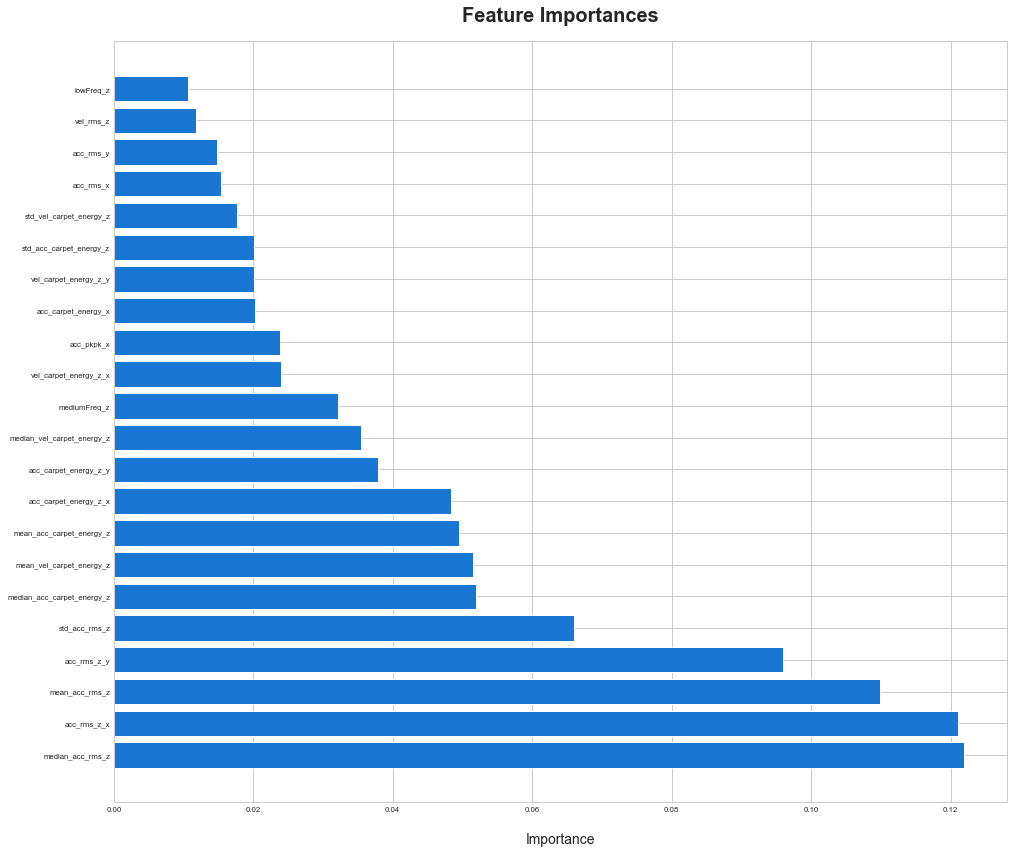

In [112]:
dset = pd.DataFrame()
dset['Feature'] = X.columns
dset['Importance'] = model.feature_importances_

dset = dset.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['Feature'], width=dset['Importance'], color='#1976D2')
plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()